# Optimal Chemical Kinetics: A Self-Driving Laboratory Approach
*By Marcus Schwarting*

__Goal:__ Develop an active learning strategy for optimizing a batch-process chemical reaction to produce a desired compound.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from pyDOE import lhs
from scipy.stats.qmc import LatinHypercube

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)
#### HIDDEN PARAMETERS ####
Arh_constant = 4e3 #unitless
catalysts_Ea_dict = {'None':{'Ea':np.random.uniform(9,11),'price':0},'alpha':{},'beta':{},'gamma':{}}
catalysts_Ea_dict['alpha']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
catalysts_Ea_dict['beta']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
catalysts_Ea_dict['gamma']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
#Ea values are in units of kJ/mol
reaction_rate_noise = 0.2

#Note: we are doing everything in mols so we don't have to deal with conversions, densities, and other stuff.
measurement_techniques = {'low_fi':{'sigma':10},\
                          'mid_fi':{'sigma':5},\
                          'high_fi':{'sigma':1},\
                          'perfect':{'sigma':0,'time':0}} #NOTE: 'perfect' is not to be used in practice
#measurement sigmas are in units of mols

In [3]:
#### KNOWN PARAMETERS ####

# aA + bB --> cX + dY
#Stoichiometric constants (selected so total number of mols does not change):
#a = np.random.choice(range(1,8))
#b = np.random.choice(range(1,8))
#d = np.random.choice(range(1,4))
#c = a+b-d
a = 3
b = 2
c = 1
d = 4

#Measurement Times
measurement_techniques['low_fi']['time']=0.2 #hours
measurement_techniques['mid_fi']['time']=0.5 #hours
measurement_techniques['high_fi']['time']=1 #hours

V = 1000 #Tank "volume", in mols
T_lower = 293 #Kelvin (room temperature)
T_upper = 800 #Kelvin
k_B = 8.314462618e-3 #Boltzmann's constant, kJ/(mol*K)

#Price of various compounds
P_A = np.random.uniform(-10,-5) #Cost to purchase A ($/mol), a negative cash flow
P_B = np.random.uniform(-10,-5) #Cost to purchase B ($/mol), a negative cash flow
P_X = np.random.uniform(50,100) #Sale price of X ($/mol), a positive cash flow
P_Y = np.random.uniform(-10,-5) #Cost to dispose of Y ($/mol), a negative cash flow

P_A0 = P_A
P_B0 = P_B
catalysts_Ea_dict['alpha']['price'] = np.random.uniform(100,300) #Cost of alpha ($)
catalysts_Ea_dict['beta']['price'] = np.random.uniform(100,300) #Cost of beta ($)
catalysts_Ea_dict['gamma']['price'] = np.random.uniform(100,300) #Cost of gamma ($)

#Price of heat
P_T = np.random.uniform(1,5) #Units of $ / (K * mol * hr). Note that this is not all that realistic...

t_min = 1
t_max = 10 #Maximum run time of ten hours on a batch

print(f'{a}A + {b}B --> {c}X + {d}Y')

3A + 2B --> 1X + 4Y


In [4]:
#TODO: Break this into a separate script...? Depends on how this will be presented to students.
Arh_rate_k = lambda A, Ea, T: A*np.exp(-Ea/(k_B*T))

class Reactor:
    def __init__(self):
        self.interval = 0.01 #Working in time steps of a tenth of an hour, or six minutes
        self.load_time = 0.5
        self.purge_time = 0.5
        self.rxn_noise_sigma = 0.2

        self.quantity_A = []
        self.quantity_B = []
        self.quantity_X = []
        self.quantity_Y = []
        self.reactor_status_list = []
        self.cash_flow_list = []
        self.profit_per_hour_list = []
        return

    def _load_reactor(self,V_A,V_B,run_temp,run_time,catalyst_choice):
        load_interval = int(self.load_time/self.interval)
        heat_cost = (run_temp-T_lower)*run_time*P_T
        load_cost = (V_A*P_A) + (V_B*P_B) + catalysts_Ea_dict[catalyst_choice]['price']+heat_cost
        self.cash_flow_list += [load_cost]+np.zeros(load_interval-1).tolist()
        self.quantity_A += np.linspace(0,V_A,load_interval,endpoint=True).tolist()
        self.quantity_B += np.linspace(0,V_B,load_interval,endpoint=True).tolist()
        self.quantity_X += np.zeros(load_interval).tolist()
        self.quantity_Y += np.zeros(load_interval).tolist()
        self.reactor_status_list += ['Loading']*load_interval
        return load_cost

    def _purge_reactor(self,V_A,V_B,measure_choice):
        purge_interval = int(self.purge_time/self.interval)
        #Add measurement noise to the process after the fact.
        m_noise = measurement_techniques[measure_choice]['sigma']
        noisy_quants = np.array([abs(self.quantity_A[-1]+np.random.normal(0,m_noise)),\
                                 abs(self.quantity_B[-1]+np.random.normal(0,m_noise)),\
                                 self.quantity_X[-1]+np.random.normal(0,m_noise),\
                                 self.quantity_Y[-1]+np.random.normal(0,m_noise)])
        noisy_quants /= np.sum(noisy_quants)
        noisy_quants *= (V_A+V_B)
        #When calculating, assume that A and B can be recycled with 100% efficiency.
        purge_cash = (noisy_quants[0]*P_A) + (noisy_quants[1]*P_B) + \
                     (noisy_quants[2]*P_X) - (noisy_quants[3]*P_Y)
        self.cash_flow_list+=np.zeros(purge_interval-1).tolist()+[purge_cash]
        self.quantity_A += np.linspace(self.quantity_A[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_B += np.linspace(self.quantity_B[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_X += np.linspace(self.quantity_X[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_Y += np.linspace(self.quantity_Y[-1],0,purge_interval,endpoint=True).tolist()
        self.reactor_status_list += ['Purging']*purge_interval
        return purge_cash

    def run_batch(self, V_A, V_B, run_temp=T_lower, run_time=t_min, catalyst_choice='None',measure_choice='low_fi'):
        #Vat is not overfilled
        assert V_A + V_B <= V
        #Within temperature range
        assert run_temp >= T_lower
        assert run_temp <= T_upper
        #Within time range
        assert run_time <= t_max
        assert run_time >= t_min
        #Correctly chose a catalyst and a measurement technique
        assert catalyst_choice in catalysts_Ea_dict.keys()
        assert measure_choice in measurement_techniques.keys()
        #Load reactor with reagents
        load_cost = self._load_reactor(V_A,V_B,run_temp,run_time,catalyst_choice)
        #Begin reaction
        reaction_const = Arh_rate_k(Arh_constant,catalysts_Ea_dict[catalyst_choice]['Ea'],run_temp)
        #reaction_const = 1000 #TODO: Fix this later by backing out what you want the reaction const to be and setting accordingly...
        #reaction_const = 100 #TODO: Fix this later by backing out what you want the reaction const to be and setting accordingly...
        full_react_interval = int(run_time*(1.0/self.interval))

        for _ in range(full_react_interval):
            react_rate = reaction_const * (self.quantity_A[-1]/(self.quantity_A[-1]+self.quantity_B[-1]))**a * \
                                          (self.quantity_B[-1]/(self.quantity_A[-1]+self.quantity_B[-1]))**b
            #react_rate units should come out to mol/hr
            rxn_noise = np.random.normal(0,self.rxn_noise_sigma)
            dA = a*(react_rate*self.interval + rxn_noise)
            dB = b*(react_rate*self.interval + rxn_noise)
            dX = c*(react_rate*self.interval + rxn_noise) #TODO: Check
            dY = d*(react_rate*self.interval + rxn_noise)
            if dA>=self.quantity_A[-1] or self.quantity_A[-1]==0: #A is limiting reagent
                self.quantity_B.append(self.quantity_B[-1]-self.quantity_A[-1]*(b/a))
                self.quantity_X.append(self.quantity_X[-1]-self.quantity_A[-1]*(c/a))
                self.quantity_Y.append(self.quantity_Y[-1]-self.quantity_A[-1]*(d/a))
                self.quantity_A.append(0.0)
            elif dB>=self.quantity_B[-1] or self.quantity_B[-1]==0: #B is limiting reagent
                self.quantity_A.append(self.quantity_A[-1]-self.quantity_B[-1]*(a/b))
                self.quantity_X.append(self.quantity_X[-1]-self.quantity_B[-1]*(c/b))
                self.quantity_Y.append(self.quantity_Y[-1]-self.quantity_B[-1]*(d/b))
                self.quantity_B.append(0.0)
            else: #Neither A nor B is limiting the continuation of the reaction
                self.quantity_A.append(self.quantity_A[-1] - dA)
                self.quantity_B.append(self.quantity_B[-1] - dB)
                self.quantity_X.append(self.quantity_X[-1] + dX)
                self.quantity_Y.append(self.quantity_Y[-1] + dY)
            self.reactor_status_list.append('Running')
            self.cash_flow_list.append(0)
        purge_cash = self._purge_reactor(V_A,V_B,measure_choice)
        batch_profit = purge_cash - load_cost
        batch_profit_per_hour = batch_profit / (run_time+self.load_time+self.purge_time)
        self.profit_per_hour_list += [batch_profit_per_hour]
        return batch_profit_per_hour

    def _plot_reaction_progress(self):
        plt.figure(figsize=(16,4))
        t_domain = np.linspace(0,len(self.quantity_A)*self.interval,len(self.quantity_A))
        plt.plot(t_domain,self.quantity_A,label='Reactant A')
        plt.plot(t_domain,self.quantity_B,label='Reactant B')
        plt.plot(t_domain,self.quantity_X,label='Product X')
        plt.plot(t_domain,self.quantity_Y,label='Product Y')

        load_starts = np.where(np.array(self.reactor_status_list)=='Loading')[0][::int(self.load_time/self.interval)]
        load_label_bool = True
        for i in load_starts:
            if load_label_bool:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.load_time/self.interval),\
                                                     len(t_domain)-1)],color='yellow',alpha=0.3,label='Loading')
                load_label_bool=False
            else:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.load_time/self.interval),\
                                                     len(t_domain)-1)],color='yellow',alpha=0.3)
        purge_starts = np.where(np.array(self.reactor_status_list)=='Purging')[0][::int(self.purge_time/self.interval)]
        purge_label_bool = True
        for i in purge_starts:
            if purge_label_bool:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.purge_time/self.interval),\
                                                     len(t_domain)-1)],color='red',alpha=0.3,label='Purging')
                purge_label_bool=False
            else:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.purge_time/self.interval),\
                                                     len(t_domain)-1)],color='red',alpha=0.3)

        react_label_bool=True
        for i in range(len(load_starts)):
            if react_label_bool:
                plt.axvspan(t_domain[load_starts[i]+int(self.load_time/self.interval)],\
                            t_domain[purge_starts[i]],color='green',alpha=0.3,label='Running')
                react_label_bool=False
            else:
                plt.axvspan(t_domain[load_starts[i]+int(self.load_time/self.interval)],\
                            t_domain[purge_starts[i]],color='green',alpha=0.3)
        plt.xlim([t_domain[0],t_domain[-1]])
        plt.xlabel('Time (hours)',fontsize=16)
        plt.ylabel('Amount of Compounds (mol)',fontsize=16)
        plt.grid()
        plt.title('Reactor Contents Over Time',fontsize=26)
        plt.legend(loc='upper right')
        plt.show()


    def _plot_profits(self):
        plt.plot(self.profit_per_hour_list)
        plt.xlabel('Batch Number',fontsize=14)
        plt.ylabel('Batch Profit ($/hr)',fontsize=14)
        plt.title('Profit Margins Across Batches',fontsize=22)
        plt.grid()
        plt.show()

P_A = P_A0
P_B = P_B0
print(P_A, P_B)
test = Reactor()
print(test.run_batch(100, 100, 293,9, "None"))

P_A = P_A0 - 1
P_B = P_B0 - 1
print(P_A, P_B)
test = Reactor()
print(f"after the discount of reactors: {test.run_batch(100, 100, 293,9, 'None')}")

-7.881726003305476 -6.770529434666719
-51.523849200497395
-8.881726003305477 -7.770529434666719
after the discount of reactors: 188.84958539078372


### Brute Force Strategies

Running a reactor with different initial concentrations of A and B.
Note that the optimal (most profitable) instance is when A and B are in proper stoichiometric ratio (3:2).

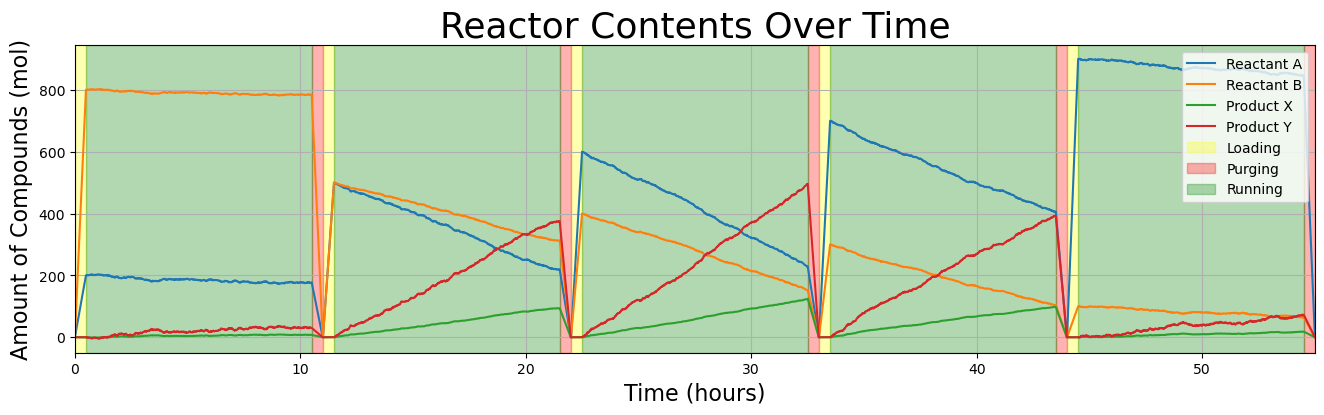

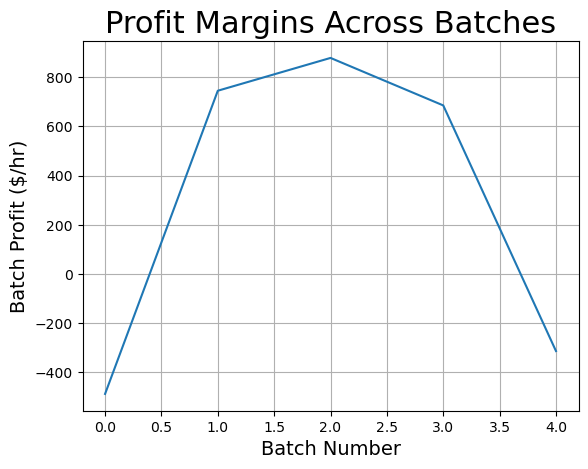

In [5]:
TEST_REACTOR = Reactor()
TEST_REACTOR.run_batch(200,800,run_time=t_max,run_temp=500)
TEST_REACTOR.run_batch(500,500,run_time=t_max,run_temp=500)
TEST_REACTOR.run_batch(600,400,run_time=t_max,run_temp=500) #Perfect stoichiometric ratio
TEST_REACTOR.run_batch(700,300,run_time=t_max,run_temp=500)
TEST_REACTOR.run_batch(900,100,run_time=t_max,run_temp=500)
TEST_REACTOR._plot_reaction_progress()
TEST_REACTOR._plot_profits()

Running a reactor at near-stoichiometric ratios, but for different amounts of time.
While the reactor gets closer to completion with longer trials, there is a diminishing return that ultimately influences profitability.

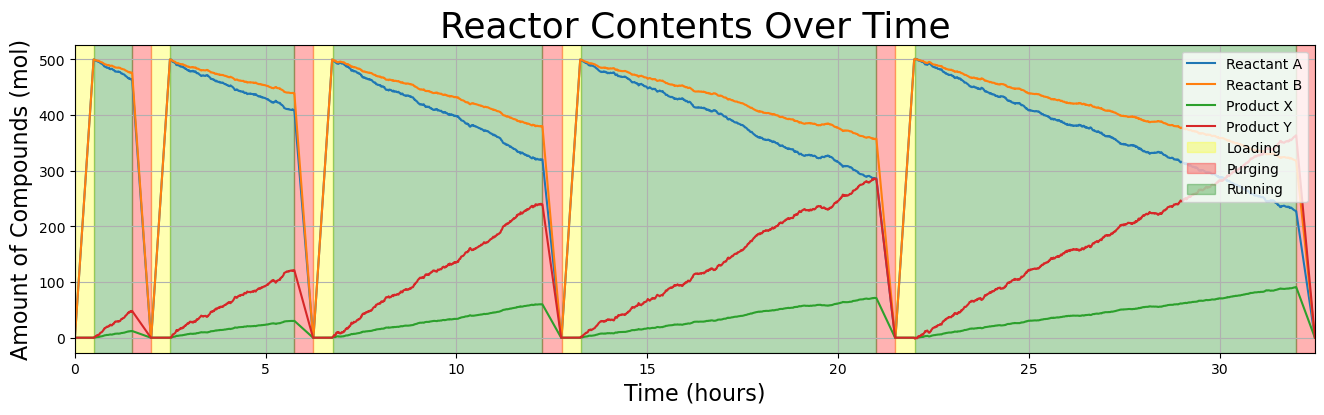

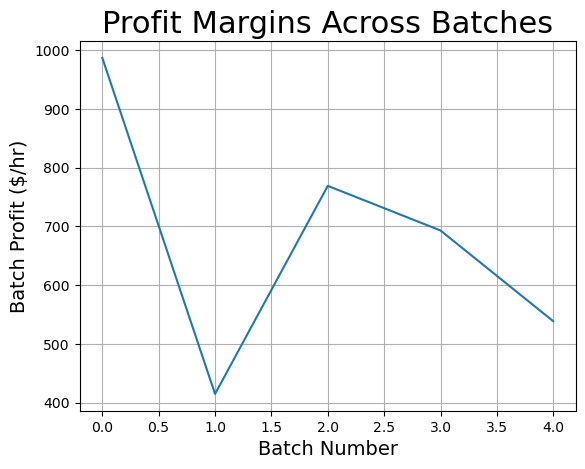

In [6]:
TEST_REACTOR = Reactor()
for i in np.linspace(t_min,t_max,5,endpoint=True):
    TEST_REACTOR.run_batch(500,500,run_time=i,run_temp=500)
TEST_REACTOR._plot_reaction_progress()
TEST_REACTOR._plot_profits()

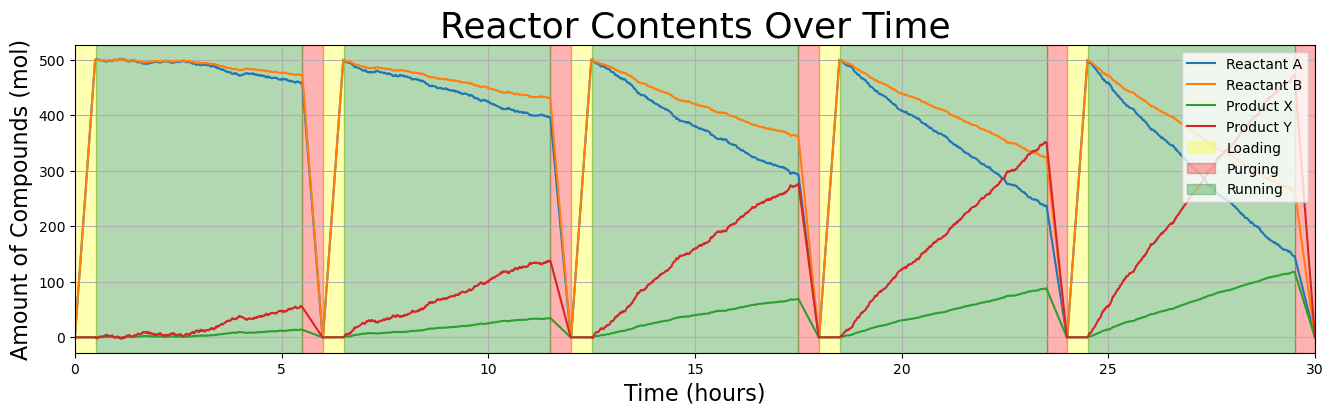

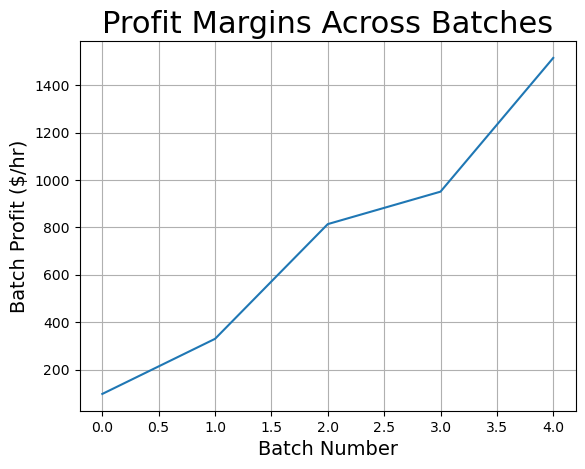

In [7]:
TEST_REACTOR = Reactor()
for i in np.linspace(T_lower,T_upper,5,endpoint=True):
    TEST_REACTOR.run_batch(500,500,run_time=5,run_temp=i)
TEST_REACTOR._plot_reaction_progress()
TEST_REACTOR._plot_profits()

*Considering* initial species concentration alongside total reaction time.
This is effectively a brute-force approach, and in practice, running all of these experiments is infeasible in practice.
For these two variables (initial concentration and temperature), students will effectively be optimizing over this noisy surface.

100%|██████████| 80/80 [00:13<00:00,  5.79it/s]


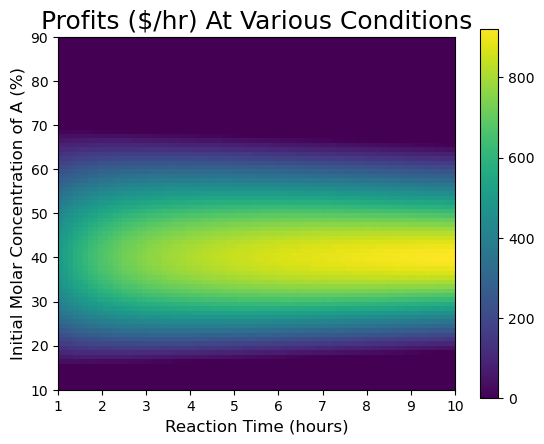

In [8]:
stoich_time_profits = []
TEST_REACTOR = Reactor()
TEST_REACTOR.rxn_noise_sigma = 0.0
for i in tqdm(np.linspace(100,900,80,endpoint=True)):
    sub_li = []
    for t in np.linspace(t_min,t_max,80,endpoint=True):
        sub_li.append(TEST_REACTOR.run_batch(i,1000-i,run_time=t,run_temp=500,measure_choice='perfect'))
    stoich_time_profits.append(sub_li)

plt.imshow(stoich_time_profits,extent=[t_min,t_max,10,90],aspect=0.1,vmin=0)
plt.xlabel('Reaction Time (hours)',fontsize=12)
plt.ylabel('Initial Molar Concentration of A (%)',fontsize=12)
plt.title('Profits ($/hr) At Various Conditions',fontsize=18)
plt.colorbar()
plt.show()

100%|██████████| 80/80 [00:13<00:00,  5.89it/s]


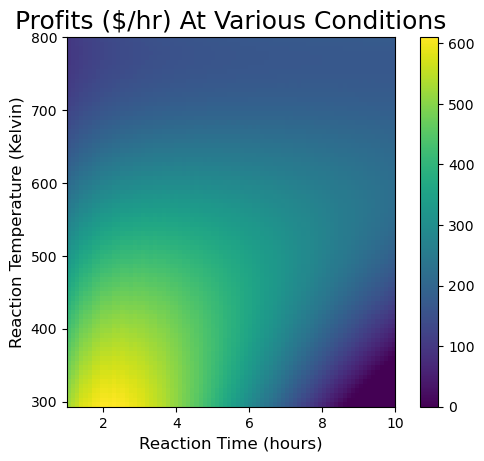

In [9]:
stoich_time_profits = []
TEST_REACTOR = Reactor()
TEST_REACTOR.rxn_noise_sigma = 0.0
for i in tqdm(np.linspace(T_lower,T_upper,80,endpoint=True)):
    sub_li = []
    for t in np.linspace(t_min,t_max,80,endpoint=True):
        sub_li.append(TEST_REACTOR.run_batch(400,600,run_time=t,run_temp=i,measure_choice='perfect'))
    stoich_time_profits.append(sub_li)

plt.imshow(stoich_time_profits,extent=[t_min,t_max,T_lower,T_upper],aspect=0.02,vmin=0)
plt.xlabel('Reaction Time (hours)',fontsize=12)
plt.ylabel('Reaction Temperature (Kelvin)',fontsize=12)
plt.title('Profits ($/hr) At Various Conditions',fontsize=18)
plt.colorbar()
plt.show()



100%|██████████| 80/80 [00:00<00:00, 521.68it/s]


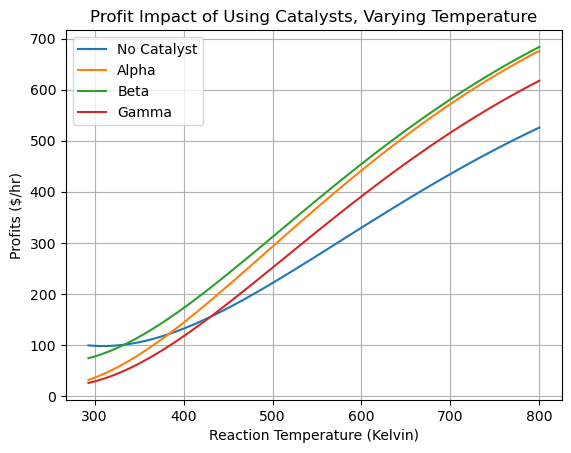

100%|██████████| 80/80 [00:00<00:00, 116.66it/s]


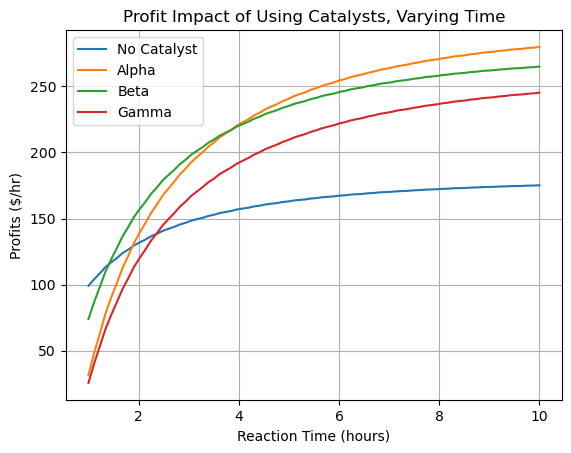

In [10]:
stoich_time_profits_Cnone = []
stoich_time_profits_Calpha = []
stoich_time_profits_Cbeta = []
stoich_time_profits_Cgamma = []

TEST_REACTOR = Reactor()
TEST_REACTOR.rxn_noise_sigma = 0.0
for i in tqdm(np.linspace(T_lower,T_upper,80,endpoint=True)):
    stoich_time_profits_Cnone.append(TEST_REACTOR.run_batch(400,600,run_temp=i,measure_choice='perfect'))
    stoich_time_profits_Calpha.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='alpha',run_temp=i,measure_choice='perfect'))
    stoich_time_profits_Cbeta.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='beta',run_temp=i,measure_choice='perfect'))
    stoich_time_profits_Cgamma.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='gamma',run_temp=i,measure_choice='perfect'))
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Cnone,label='No Catalyst')
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Calpha,label='Alpha')
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Cbeta,label='Beta')
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Cgamma,label='Gamma')
plt.grid()
plt.xlabel('Reaction Temperature (Kelvin)')
plt.ylabel('Profits ($/hr)')
plt.title('Profit Impact of Using Catalysts, Varying Temperature')
plt.legend()
plt.show()

stoich_time_profits_Cnone = []
stoich_time_profits_Calpha = []
stoich_time_profits_Cbeta = []
stoich_time_profits_Cgamma = []

for i in tqdm(np.linspace(t_min,t_max,80,endpoint=True)):
    stoich_time_profits_Cnone.append(TEST_REACTOR.run_batch(400,600,run_time=i,measure_choice='perfect'))
    stoich_time_profits_Calpha.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='alpha',run_time=i,measure_choice='perfect'))
    stoich_time_profits_Cbeta.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='beta',run_time=i,measure_choice='perfect'))
    stoich_time_profits_Cgamma.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='gamma',run_time=i,measure_choice='perfect'))
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Cnone,label='No Catalyst')
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Calpha,label='Alpha')
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Cbeta,label='Beta')
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Cgamma,label='Gamma')
plt.grid()
plt.xlabel('Reaction Time (hours)')
plt.ylabel('Profits ($/hr)')
plt.title('Profit Impact of Using Catalysts, Varying Time')
plt.legend()
plt.show()

In [11]:
all_processes = []


for temp in tqdm(np.linspace(T_lower,T_upper,20,endpoint=True)):
    for r_time in np.linspace(t_min,t_max,20,endpoint=True):
        TEST_REACTOR = Reactor()
        TEST_REACTOR.rxn_noise_sigma = 0.0
        for stoich in np.linspace(100,900,20,endpoint=True):
            for cat_choice in ['None','alpha','beta','gamma']:
                all_processes.append([temp,r_time,stoich,cat_choice,\
                                    TEST_REACTOR.run_batch(stoich,1000-stoich,catalyst_choice=cat_choice,\
                                    run_temp=temp,run_time=r_time,measure_choice='perfect')])

100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


In [12]:
len(all_processes)

32000

In [13]:
print('Best Overall Conditions (Via Brute Force):')
print(all_processes[np.argmax([i[-1] for i in all_processes])])

Best Overall Conditions (Via Brute Force):
[800.0, 5.263157894736842, 605.2631578947369, 'alpha', 2866.085126049702]


#### Use lhs to create data called all_processes and use it to test the model 

In [14]:
a = 3
b = 2
c = 1
d = 4
measurement_techniques['low_fi']['time']=0.2 #hours
measurement_techniques['mid_fi']['time']=0.5 #hours
measurement_techniques['high_fi']['time']=1 #hours
V = 1000 #Tank "volume", in mols
T_lower = 293 #Kelvin (room temperature)
T_upper = 800 #Kelvin
t_min = 1
t_max = 10 #Maximum run time of ten hours on a batc
stoich_min = 0
stoich_max = V
cat_choices = ['None', 'alpha', 'beta', 'gamma']

# Number of samples
n_samples = 300

# Create Latin Hypercube Sampling design
lhs_design = lhs(3, samples=n_samples)  # 3 continuous parameters: temp, r_time, stoich

# Scale the LHS samples to the parameter ranges
temperatures = T_lower + (T_upper - T_lower) * lhs_design[:, 0]
reaction_times = t_min + (t_max - t_min) * lhs_design[:, 1]
stoichiometries = stoich_min + (stoich_max - stoich_min) * lhs_design[:, 2]

all_processes = []
for temp, r_time, stoich in tqdm(zip(temperatures, reaction_times, stoichiometries), total=n_samples):
    TEST_REACTOR = Reactor()
    for cat_choice in cat_choices:
        stoich_A = stoich
        stoich_B = V - stoich
        output = TEST_REACTOR.run_batch(stoich_A, stoich_B, run_temp = temp,  run_time = r_time, catalyst_choice = cat_choice, measure_choice = 'perfect')
    # def run_batch(self, V_A, V_B, run_temp=T_lower, run_time=t_min, catalyst_choice='None',measure_choice='low_fi'):
        all_processes.append([temp, r_time, stoich, cat_choice, output])

100%|██████████| 300/300 [00:02<00:00, 116.59it/s]


## 20 points: Build a model surrogate with UQ to predict outcomes of particular situations (without running Reactor() class)

### Use Gussian Process Regression as a surrogate model and measure its uncertainty

In [15]:
# Assuming all_processes is already filled with data
data = pd.DataFrame(all_processes, columns=['temp', 'r_time', 'stoich', 'cat_choice', 'output'])

# Splitting the dataset into features and target
X = data[['temp', 'r_time', 'stoich', 'cat_choice']]
y = data['output']

# Encoding categorical data and setting up the pipeline with Gaussian Process
categorical_features = ['cat_choice']
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ], remainder='passthrough')

# Define the kernel: Matern kernel is often a good choice in physical sciences
kernel = C(1.0, (1e-3, 1e3)) * RBF([1, 1, 1, 1, 1, 1, 1])

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10, normalize_y=True)

scaler = StandardScaler()

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('scaler', scaler), 
                        ('regressor', gpr)])
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Storing results for plotting
test_indexes = []
predictions = []
uncertainties = []

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Predict the output
    y_pred, sigma = model.predict(X_test, return_std=True)
    
    # Store results
    test_indexes.extend(test_index)
    predictions.extend(y_pred)
    uncertainties.extend(sigma)

# Sorting results for plotting (by test indexes)
sorted_indexes = np.argsort(test_indexes)
sorted_predictions = np.array(predictions)[sorted_indexes]
sorted_uncertainties = np.array(uncertainties)[sorted_indexes]
sorted_y_test = y.iloc[test_indexes].values[sorted_indexes]

# Plotting results and uncertainty

5it [06:05, 73.08s/it]


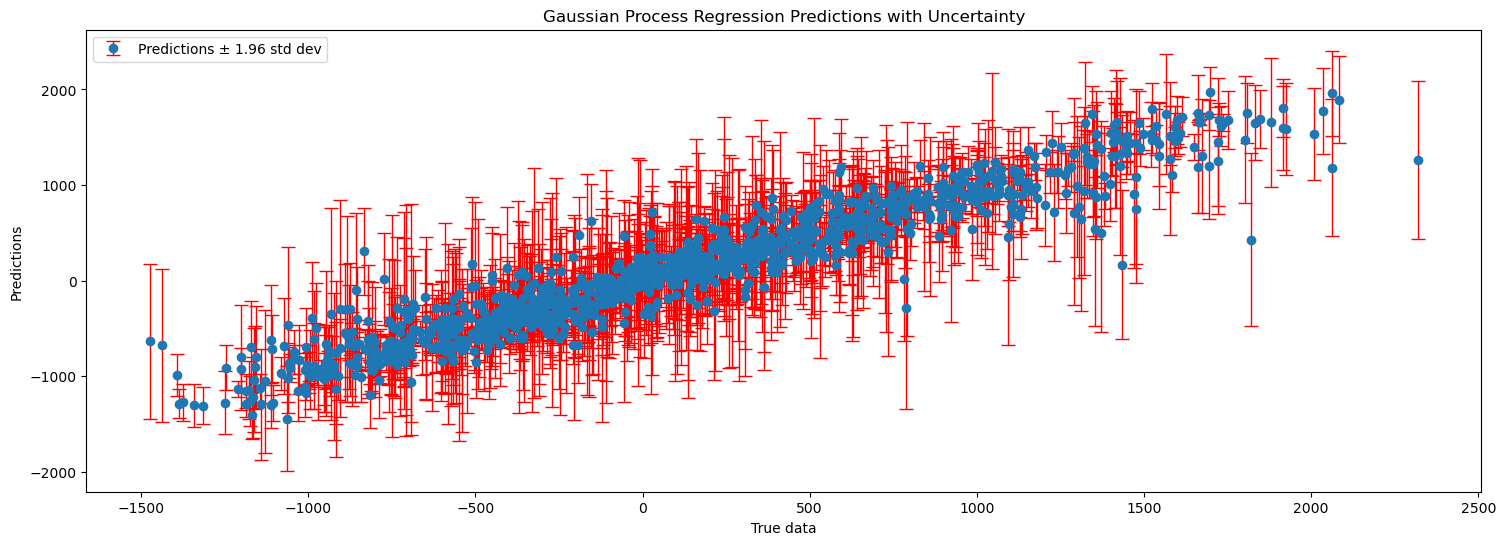

In [16]:
plt.figure(figsize=(18, 6))
# Use 1.96 since 95% in normal distribution is covered in ± 1.96 sigma
plt.errorbar(sorted_y_test, sorted_predictions, yerr=1.96 * sorted_uncertainties, fmt='o', label='Predictions ± 1.96 std dev', ecolor='r', capsize=5, elinewidth = 1)
plt.title('Gaussian Process Regression Predictions with Uncertainty')
plt.xlabel('True data')
plt.ylabel('Predictions')
plt.legend()
plt.savefig("UQ_plot.png")
plt.show()

## 20 points: Design an acquisition function that balances explore versus exploit tradeoffs. Justify your design choices.

In [17]:
def upper_confidence_bound(X, model, kappa=2.0):
    mu, sigma = model.predict(X, return_std=True)
    return mu + kappa * sigma

Here I used a simple __Upper Confidence Bound (UCB)__ function which combines both aspects

Exploration is controlled by the `sigma` term. Higher uncertainty increases the value of the UCB.

Exploitation is represented by the `mu` term. Higher predicted values increase the UCB.

kappa adjusts the balance between exploration and exploitation. Higher values favor exploration.

## 20 points: Build a process for Bayesian optimization: surrogate predictions --> condition selection --> run reactor --> retrain surrogate --> repeat

In [18]:
def generate_initial_data(method='lhs', n_samples=50, bounds=None):
    print("initialize new data!")
    if method == 'random':
        samples = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_samples, bounds.shape[0]))
    elif method == 'lhs':
        sampler = LatinHypercube(d=bounds.shape[0])
        samples = sampler.random(n=n_samples)
        samples = bounds[:, 0] + (bounds[:, 1] - bounds[:, 0]) * samples  # Scale to bounds

    cat_choices = np.random.choice(['None', 'alpha', 'beta', 'gamma'], n_samples)
    outputs = []
    initial_data = []
    for i, (sample, cat_choice) in enumerate(zip(samples, cat_choices)):
        V_A = sample[2]
        V_B = V - V_A  # Ensure total volume is 1000
        run_temp = sample[0]
        run_time = sample[1]
        output = TEST_REACTOR.run_batch(V_A, V_B, run_temp, run_time, cat_choice, 'perfect')
        outputs.append(output)
        initial_data.append([V_A, V_B, run_temp, run_time, cat_choice, output])

    return initial_data
    
# Define bounds for the parameters
bounds = np.array([[293, 800], [1, 10], [0, 1000]])

# Instantiate Reactor
TEST_REACTOR = Reactor()

# Generate initial data
initial_samples = generate_initial_data(n_samples=50, bounds=bounds)
all_processes = initial_samples

initialize new data!


In [19]:
def update_surrogate(conditions=None, profit=None):
    # global all_processes  # Ensure all_processes is globally accessible and modifiable
    if conditions is not None and profit is not None:
        all_processes.append(conditions.tolist() + [profit])
    
    data = pd.DataFrame(all_processes, columns=['V_A', 'V_B', 'run_temp', 'run_time', 'cat_choice', 'output'])
    
    # Ensure 'cat_choice' is correctly handled as a categorical feature
    X = data[['V_A', 'V_B', 'run_temp', 'run_time', 'cat_choice']]
    y = data['output']
    
    categorical_features = ['cat_choice']
    categorical_transformer = OneHotEncoder(categories=[['None', 'alpha', 'beta', 'gamma']], handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features)
        ], remainder='passthrough')
    
    # Configure kernel with an appropriate number of dimensions for the input data
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler())
    ])
    X_transformed = pipeline.fit_transform(X)
    n_features = X_transformed.shape[1]
    new_upper_bound = 1e6  # For example, increase to 1,000,000
    kernel = C(1.0, (1e-3, 1e3)) * RBF([1] * n_features, (1e-6, new_upper_bound))
    # kernel = C(1.0, (1e-3, 1e3)) * RBF([1, 1, 1, 1, 1, 1, 1])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, 
                                       alpha=1e-5,
                                       normalize_y=True)
    
    # Complete model pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()), 
        ('regressor', gpr)])
    model.fit(X, y)
    return model
    
def select_conditions(model):
    # def upper_confidence_bound(X, model, kappa=2):
    #     # Ensure X is in the correct format (DataFrame) before prediction
    #     mu, sigma = model.predict(X, return_std=True)
    #     return mu + kappa * sigma  # UCB acquisition function

    # Sample total volume V, where V = V_A + V_B and V <= 1000
    V = np.random.uniform(0, 1000, 5000)
    V_A = np.random.uniform(0, V)
    V_B = V - V_A

    # Sample temperatures and reaction times within their bounds
    temperatures = np.random.uniform(293, 800, 5000)
    reaction_times = np.random.uniform(1, 10, 5000)

    # Randomly select 'cat_choice'
    cat_choices = np.random.choice(['None', 'alpha', 'beta', 'gamma'], 5000)

    # Create a DataFrame for the combined sampled data
    X_combined = pd.DataFrame({
        'V_A': V_A,
        'V_B': V_B,
        'run_temp': temperatures,
        'run_time': reaction_times,
        'cat_choice': cat_choices
    })

    # Evaluate using the UCB acquisition function
    acquisitions = upper_confidence_bound(X_combined, model)
    
    # Find the best sample based on the acquisition values
    best_index = np.argmax(acquisitions)
    best_conditions = X_combined.iloc[best_index]

    return best_conditions

TEST_REACTOR = Reactor()  # Instantiate Reactor

In [20]:
def bayesian_optimization(num_iterations=50):
    model = update_surrogate()  # Initialize the surrogate model without any data
    profits = []  # List to store profits from each iteration

    for _ in tqdm(range(num_iterations)):
        conditions = select_conditions(model)
        # print(conditions)
        profit = TEST_REACTOR.run_batch(*conditions, measure_choice='perfect')
        profits.append(profit)  # Log the observed profit
        model = update_surrogate(conditions, profit)
        
    best_conditions = all_processes[np.argmax([p[-1] for p in all_processes])]
    
    # Plot the profits over iterations to show improvement
    plt.figure(figsize=(10, 5))
    plt.plot(profits, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Profit')
    plt.title('Profit Improvement Over Iterations Using Bayesian Optimization')
    plt.grid(True)
    
    # Display best conditions as text on the plot
    # best_conditions_str = "V_A, V_B, run_temp, run_time, cat_choice \n" + ','.join(f"{c}" for c in best_conditions)
    best_conditions_str = "\n V_A, V_B, run_temp, run_time, cat_choice, profit \n" + ', '.join(f"{c:.2f}" if isinstance(c, (int, float)) else c for c in best_conditions)
    plt.text(x = 0, y = np.median(profits), s = f"Best Conditions: {best_conditions_str}", alpha=0.5, 
             verticalalignment='top', color= "gray", size = "x-large")
    # plt.savefig(f"{num_iterations}_{np.max(profits):.2f}.png")
    plt.show()
    
    return best_conditions

# # Run Bayesian optimization and plot improvements
# all_processes = generate_initial_data(n_samples=50, bounds=bounds) 
# best_conditions = bayesian_optimization(20)  

## 10 points: Demonstrate how your Bayesian optimization process improves profitability over batches, and quantify the improvement

## 10 points: Demonstrate how changing the explore/exploit tradeoff affects profitability, and quantify the change

**The explore/exploit tradeoff can be adjusted by tweaking the `kappa` in the Upper Confidence Bound function. The larger the `kappa` is, the more the function is likely to explore the global structure. If we use smaller `kappa` value, the Bayesian optimization is more likely to exploit the local structure.** 


_I will demonstrate how teh BO improves profitability over batches and how changing the explore/exploit tradeoff affects profitability, and quantify the change at the same time._

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


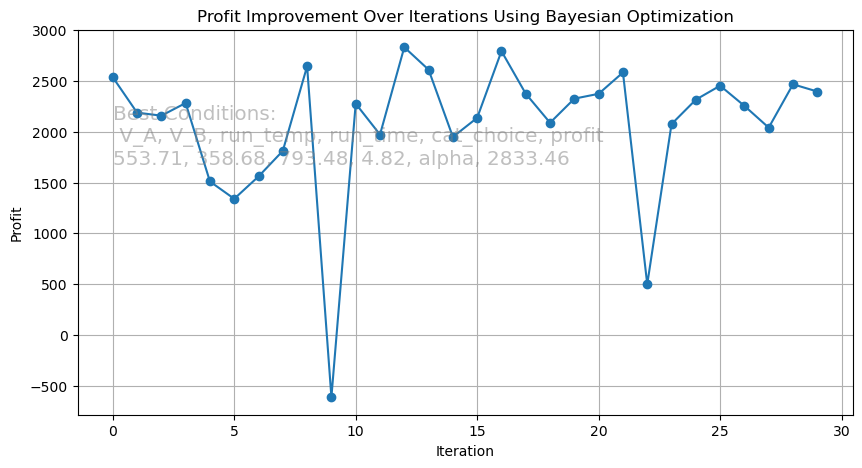

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


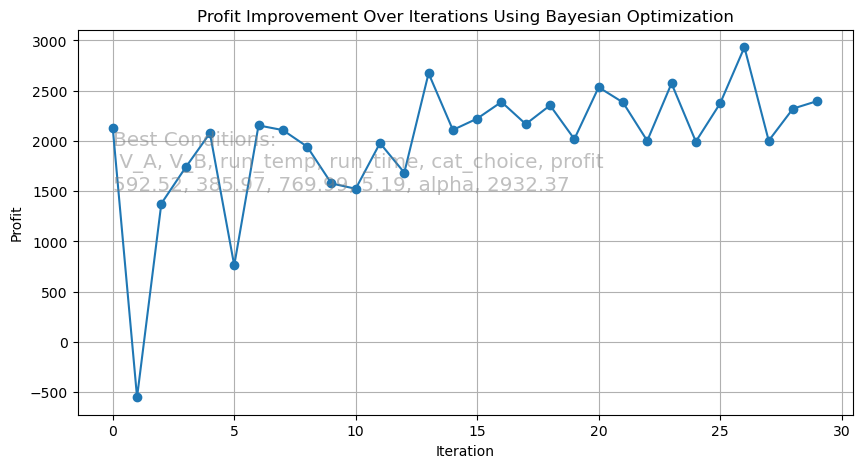

initialize new data!


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


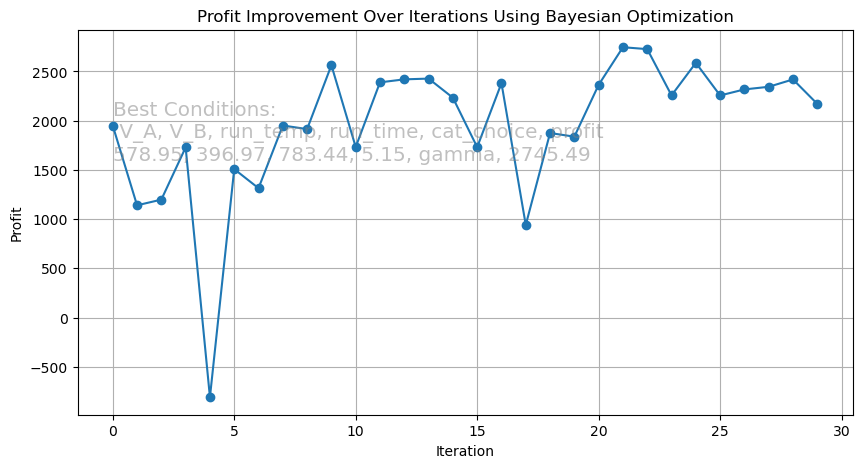

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


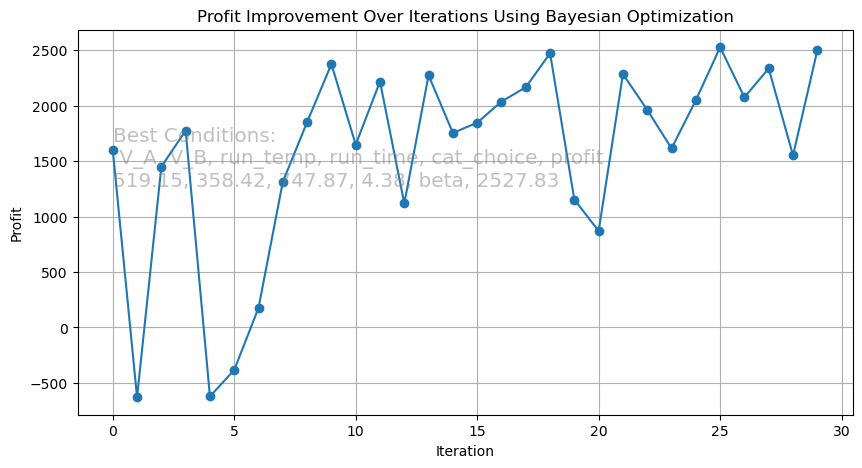

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


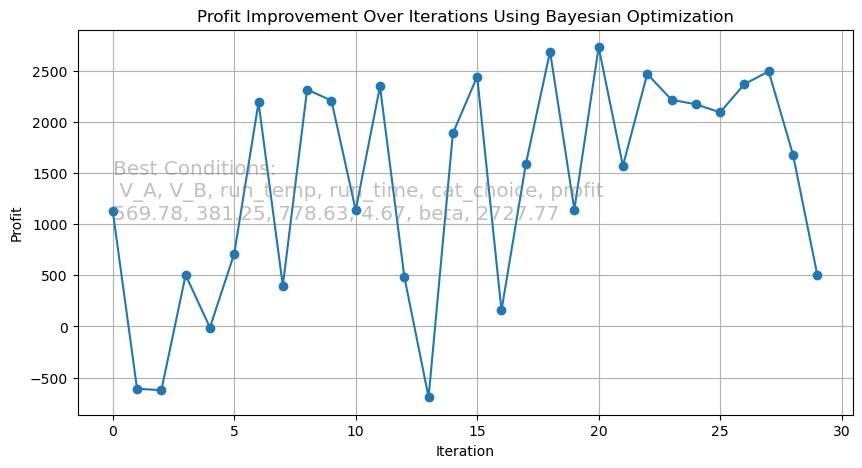

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


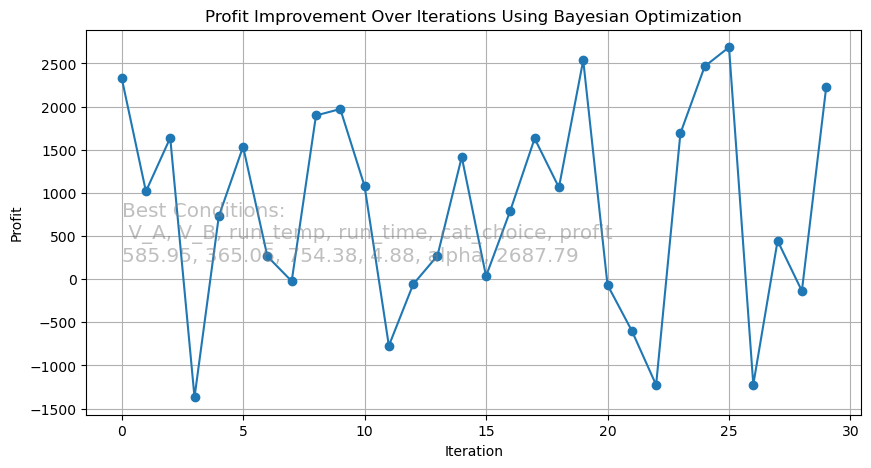

In [21]:
kappa_list = [0.01, 0.1, 0.5, 1, 2, 3]
best_profits = []
for kp in kappa_list:
    all_processes = generate_initial_data(n_samples=20, bounds=bounds) 
    def upper_confidence_bound(X, model, kappa=kp):
        # Ensure X is in the correct format (DataFrame) before prediction
        mu, sigma = model.predict(X, return_std=True)
        return mu + kappa * sigma  # UCB acquisition function
    best_conditions = bayesian_optimization(30)  
    best_profits.append(best_conditions[5])

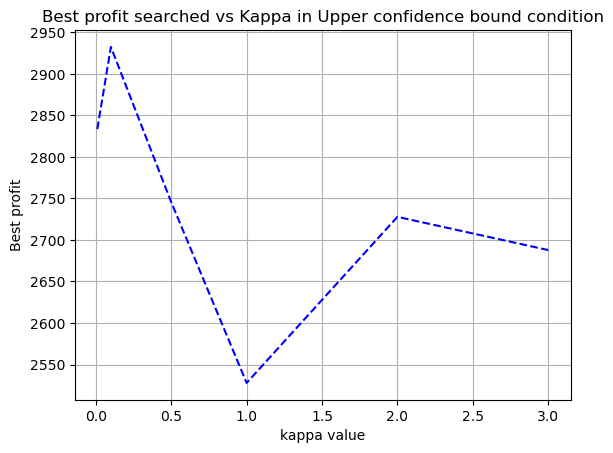

In [22]:
plt.plot(kappa_list, best_profits, "b--") 
plt.xlabel('kappa value')
plt.ylabel('Best profit')
plt.title('Best profit searched vs Kappa in Upper confidence bound condition')
plt.grid(True)

If we use the larger kappa, the Bayesian optimization will more likely to explore the global optimal rather than exploit the local optimal. We can also see from the plots. When the `kappa` is high, the result usually jumps in different global state. But when the `kappa` is set low, Bayesian optimization can explore the local maxium of the function. 

## 20 points: Explore and implement some additional considerations or constraints. Be creative! Describe your methods and results in a short report.
_The report is attached in the final paragraph_

Suppose that since we need A and B for the reaction, the mechandizer of A and B both suggest they can give us some discount. mechandizer of B says they might give us more discount to make us use more B in our reactions. Therefore, when I buy more product, the price will be cheaper. 

Suppose the prize is listed as follows:

$$self.P_A = P_A * (1 - 0.5*V_A/V)$$
$$self.P_B = P_B * (1 - 0.9*V_B/V)$$

In [23]:
np.random.seed(0)
#### HIDDEN PARAMETERS ####
Arh_constant = 4e3 #unitless
catalysts_Ea_dict = {'None':{'Ea':np.random.uniform(9,11),'price':0},'alpha':{},'beta':{},'gamma':{}}
catalysts_Ea_dict['alpha']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
catalysts_Ea_dict['beta']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
catalysts_Ea_dict['gamma']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
#Ea values are in units of kJ/mol
reaction_rate_noise = 0.2

#Note: we are doing everything in mols so we don't have to deal with conversions, densities, and other stuff.
measurement_techniques = {'low_fi':{'sigma':10},\
                          'mid_fi':{'sigma':5},\
                          'high_fi':{'sigma':1},\
                          'perfect':{'sigma':0,'time':0}} #NOTE: 'perfect' is not to be used in practice
#measurement sigmas are in units of mols

In [24]:
a = 3
b = 2
c = 1
d = 4

#Measurement Times
measurement_techniques['low_fi']['time']=0.2 #hours
measurement_techniques['mid_fi']['time']=0.5 #hours
measurement_techniques['high_fi']['time']=1 #hours

V = 1000 #Tank "volume", in mols
T_lower = 293 #Kelvin (room temperature)
T_upper = 800 #Kelvin
k_B = 8.314462618e-3 #Boltzmann's constant, kJ/(mol*K)

#Price of various compounds
P_A = np.random.uniform(-10,-5) #Cost to purchase A ($/mol), a negative cash flow
P_B = np.random.uniform(-10,-5) #Cost to purchase B ($/mol), a negative cash flow
P_X = np.random.uniform(50,100) #Sale price of X ($/mol), a positive cash flow
P_Y = np.random.uniform(-10,-5) #Cost to dispose of Y ($/mol), a negative cash flow

catalysts_Ea_dict['alpha']['price'] = np.random.uniform(100,300) #Cost of alpha ($)
catalysts_Ea_dict['beta']['price'] = np.random.uniform(100,300) #Cost of beta ($)
catalysts_Ea_dict['gamma']['price'] = np.random.uniform(100,300) #Cost of gamma ($)

#Price of heat
P_T = np.random.uniform(1,5) #Units of $ / (K * mol * hr). Note that this is not all that realistic...

t_min = 1
t_max = 10 #Maximum run time of ten hours on a batch

print(f'{a}A + {b}B --> {c}X + {d}Y')

3A + 2B --> 1X + 4Y


In [25]:
#TODO: Break this into a separate script...? Depends on how this will be presented to students.
Arh_rate_k = lambda A, Ea, T: A*np.exp(-Ea/(k_B*T))

class Reactor:
    def __init__(self):
        self.interval = 0.01 #Working in time steps of a tenth of an hour, or six minutes
        self.load_time = 0.5
        self.purge_time = 0.5
        self.rxn_noise_sigma = 0.2
        # Since we might use less B than A, the mechanizer of B says they may give as much as 50% off if we use a certain percentage of B in our result. 
        # mechanizer of A also have the similar activity. They at most gives 10% off. 
        self.quantity_A = []
        self.quantity_B = []
        self.quantity_X = []
        self.quantity_Y = []
        self.reactor_status_list = []
        self.cash_flow_list = []
        self.profit_per_hour_list = []
        return

    def _load_reactor(self,V_A,V_B,run_temp,run_time,catalyst_choice):
        load_interval = int(self.load_time/self.interval)
        heat_cost = (run_temp-T_lower)*run_time*P_T
        # print(self.P_A, self.P_B)
        load_cost = (V_A*self.P_A) + (V_B*self.P_B) + catalysts_Ea_dict[catalyst_choice]['price']+heat_cost
        self.cash_flow_list += [load_cost]+np.zeros(load_interval-1).tolist()
        self.quantity_A += np.linspace(0,V_A,load_interval,endpoint=True).tolist()
        self.quantity_B += np.linspace(0,V_B,load_interval,endpoint=True).tolist()
        self.quantity_X += np.zeros(load_interval).tolist()
        self.quantity_Y += np.zeros(load_interval).tolist()
        self.reactor_status_list += ['Loading']*load_interval
        return load_cost

    def _purge_reactor(self,V_A,V_B,measure_choice):
        purge_interval = int(self.purge_time/self.interval)
        #Add measurement noise to the process after the fact.
        m_noise = measurement_techniques[measure_choice]['sigma']
        noisy_quants = np.array([abs(self.quantity_A[-1]+np.random.normal(0,m_noise)),\
                                 abs(self.quantity_B[-1]+np.random.normal(0,m_noise)),\
                                 self.quantity_X[-1]+np.random.normal(0,m_noise),\
                                 self.quantity_Y[-1]+np.random.normal(0,m_noise)])
        noisy_quants /= np.sum(noisy_quants)
        noisy_quants *= (V_A+V_B)
        #When calculating, assume that A and B can be recycled with 100% efficiency.
        purge_cash = (noisy_quants[0]*self.P_A) + (noisy_quants[1]*self.P_B) + \
                     (noisy_quants[2]*P_X) - (noisy_quants[3]*P_Y)
        self.cash_flow_list+=np.zeros(purge_interval-1).tolist()+[purge_cash]
        self.quantity_A += np.linspace(self.quantity_A[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_B += np.linspace(self.quantity_B[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_X += np.linspace(self.quantity_X[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_Y += np.linspace(self.quantity_Y[-1],0,purge_interval,endpoint=True).tolist()
        self.reactor_status_list += ['Purging']*purge_interval
        return purge_cash

    def run_batch(self, V_A, V_B, run_temp=T_lower, run_time=t_min, catalyst_choice='None',measure_choice='low_fi'):
        #Vat is not overfilled
        assert V_A + V_B <= V
        #Within temperature range
        assert run_temp >= T_lower
        assert run_temp <= T_upper
        #Within time range
        assert run_time <= t_max
        assert run_time >= t_min
        #Correctly chose a catalyst and a measurement technique
        assert catalyst_choice in catalysts_Ea_dict.keys()
        assert measure_choice in measurement_techniques.keys()
        #Load reactor with reagents
        
        self.P_A = P_A * (1 - 0.5*V_A/V)
        self.P_B = P_B * (1 - 0.9*V_B/V)
        load_cost = self._load_reactor(V_A,V_B,run_temp,run_time,catalyst_choice)
        #Begin reaction
        reaction_const = Arh_rate_k(Arh_constant,catalysts_Ea_dict[catalyst_choice]['Ea'],run_temp)
        #reaction_const = 1000 #TODO: Fix this later by backing out what you want the reaction const to be and setting accordingly...
        #reaction_const = 100 #TODO: Fix this later by backing out what you want the reaction const to be and setting accordingly...
        full_react_interval = int(run_time*(1.0/self.interval))

        for _ in range(full_react_interval):
            react_rate = reaction_const * (self.quantity_A[-1]/(self.quantity_A[-1]+self.quantity_B[-1]))**a * \
                                          (self.quantity_B[-1]/(self.quantity_A[-1]+self.quantity_B[-1]))**b
            #react_rate units should come out to mol/hr
            rxn_noise = np.random.normal(0,self.rxn_noise_sigma)
            dA = a*(react_rate*self.interval + rxn_noise)
            dB = b*(react_rate*self.interval + rxn_noise)
            dX = c*(react_rate*self.interval + rxn_noise) #TODO: Check
            dY = d*(react_rate*self.interval + rxn_noise)
            if dA>=self.quantity_A[-1] or self.quantity_A[-1]==0: #A is limiting reagent
                self.quantity_B.append(self.quantity_B[-1]-self.quantity_A[-1]*(b/a))
                self.quantity_X.append(self.quantity_X[-1]-self.quantity_A[-1]*(c/a))
                self.quantity_Y.append(self.quantity_Y[-1]-self.quantity_A[-1]*(d/a))
                self.quantity_A.append(0.0)
            elif dB>=self.quantity_B[-1] or self.quantity_B[-1]==0: #B is limiting reagent
                self.quantity_A.append(self.quantity_A[-1]-self.quantity_B[-1]*(a/b))
                self.quantity_X.append(self.quantity_X[-1]-self.quantity_B[-1]*(c/b))
                self.quantity_Y.append(self.quantity_Y[-1]-self.quantity_B[-1]*(d/b))
                self.quantity_B.append(0.0)
            else: #Neither A nor B is limiting the continuation of the reaction
                self.quantity_A.append(self.quantity_A[-1] - dA)
                self.quantity_B.append(self.quantity_B[-1] - dB)
                self.quantity_X.append(self.quantity_X[-1] + dX)
                self.quantity_Y.append(self.quantity_Y[-1] + dY)
            self.reactor_status_list.append('Running')
            self.cash_flow_list.append(0)
        purge_cash = self._purge_reactor(V_A,V_B,measure_choice)
        # There might be some problem, but I do not change it...
        batch_profit = purge_cash - load_cost
        batch_profit_per_hour = batch_profit / (run_time+self.load_time+self.purge_time)
        self.profit_per_hour_list += [batch_profit_per_hour]
        return batch_profit_per_hour

    def _plot_reaction_progress(self):
        plt.figure(figsize=(16,4))
        t_domain = np.linspace(0,len(self.quantity_A)*self.interval,len(self.quantity_A))
        plt.plot(t_domain,self.quantity_A,label='Reactant A')
        plt.plot(t_domain,self.quantity_B,label='Reactant B')
        plt.plot(t_domain,self.quantity_X,label='Product X')
        plt.plot(t_domain,self.quantity_Y,label='Product Y')

        load_starts = np.where(np.array(self.reactor_status_list)=='Loading')[0][::int(self.load_time/self.interval)]
        load_label_bool = True
        for i in load_starts:
            if load_label_bool:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.load_time/self.interval),\
                                                     len(t_domain)-1)],color='yellow',alpha=0.3,label='Loading')
                load_label_bool=False
            else:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.load_time/self.interval),\
                                                     len(t_domain)-1)],color='yellow',alpha=0.3)
        purge_starts = np.where(np.array(self.reactor_status_list)=='Purging')[0][::int(self.purge_time/self.interval)]
        purge_label_bool = True
        for i in purge_starts:
            if purge_label_bool:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.purge_time/self.interval),\
                                                     len(t_domain)-1)],color='red',alpha=0.3,label='Purging')
                purge_label_bool=False
            else:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.purge_time/self.interval),\
                                                     len(t_domain)-1)],color='red',alpha=0.3)

        react_label_bool=True
        for i in range(len(load_starts)):
            if react_label_bool:
                plt.axvspan(t_domain[load_starts[i]+int(self.load_time/self.interval)],\
                            t_domain[purge_starts[i]],color='green',alpha=0.3,label='Running')
                react_label_bool=False
            else:
                plt.axvspan(t_domain[load_starts[i]+int(self.load_time/self.interval)],\
                            t_domain[purge_starts[i]],color='green',alpha=0.3)
        plt.xlim([t_domain[0],t_domain[-1]])
        plt.xlabel('Time (hours)',fontsize=16)
        plt.ylabel('Amount of Compounds (mol)',fontsize=16)
        plt.grid()
        plt.title('Reactor Contents Over Time',fontsize=26)
        plt.legend(loc='upper right')
        plt.show()


    def _plot_profits(self):
        plt.plot(self.profit_per_hour_list)
        plt.xlabel('Batch Number',fontsize=14)
        plt.ylabel('Batch Profit ($/hr)',fontsize=14)
        plt.title('Profit Margins Across Batches',fontsize=22)
        plt.grid()
        plt.show()
        
TEST_REACTOR = Reactor()

In [26]:
def bayesian_optimization(num_iterations=50):
    model = update_surrogate()  # Initialize the surrogate model without any data
    profits = []  # List to store profits from each iteration

    for _ in tqdm(range(num_iterations)):
        conditions = select_conditions(model)
        # print(conditions)
        profit = TEST_REACTOR.run_batch(*conditions, measure_choice='perfect')
        profits.append(profit)  # Log the observed profit
        model = update_surrogate(conditions, profit)
        
    best_conditions = all_processes[np.argmax([p[-1] for p in all_processes])]
    
    # Plot the profits over iterations to show improvement
    plt.figure(figsize=(10, 5))
    plt.plot(profits, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Profit')
    plt.title('Profit Improvement Over Iterations Using Bayesian Optimization')
    plt.grid(True)
    
    # Display best conditions as text on the plot
    # best_conditions_str = "V_A, V_B, run_temp, run_time, cat_choice \n" + ','.join(f"{c}" for c in best_conditions)
    best_conditions_str = "\n V_A, V_B, run_temp, run_time, cat_choice, profit \n" + ', '.join(f"{c:.2f}" if isinstance(c, (int, float)) else c for c in best_conditions)
    plt.text(x = 0, y = np.median(profits), s = f"Best Conditions: {best_conditions_str}", alpha=0.5, 
             verticalalignment='top', color= "gray", size = "x-large")
    plt.savefig(f"{num_iterations}_{np.max(profits):.2f}.png")
    plt.show()
    
    return best_conditions

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.79it/s]


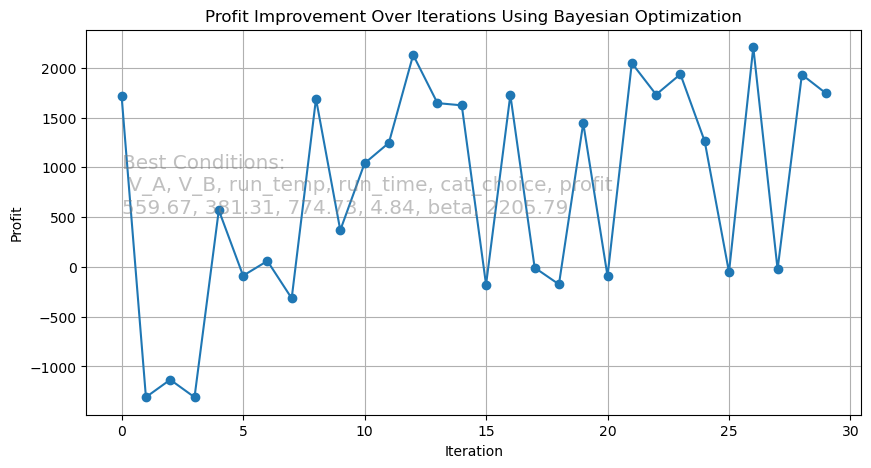

In [27]:
all_processes = generate_initial_data(n_samples=20, bounds=bounds) 
def upper_confidence_bound(X, model, kappa=3):
    # Ensure X is in the correct format (DataFrame) before prediction
    mu, sigma = model.predict(X, return_std=True)
    return mu + kappa * sigma  # UCB acquisition function
best_conditions = bayesian_optimization(num_iterations=30)  

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


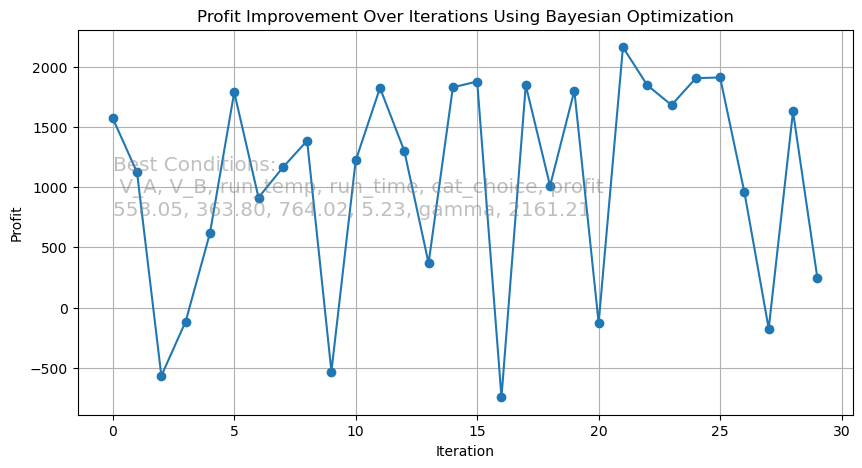

In [28]:
all_processes = generate_initial_data(n_samples=20, bounds=bounds) 
def upper_confidence_bound(X, model, kappa=2):
    # Ensure X is in the correct format (DataFrame) before prediction
    mu, sigma = model.predict(X, return_std=True)
    return mu + kappa * sigma  # UCB acquisition function
best_conditions = bayesian_optimization(num_iterations=30)  
# plt.savefig("BO_test_kappa_2.png")

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


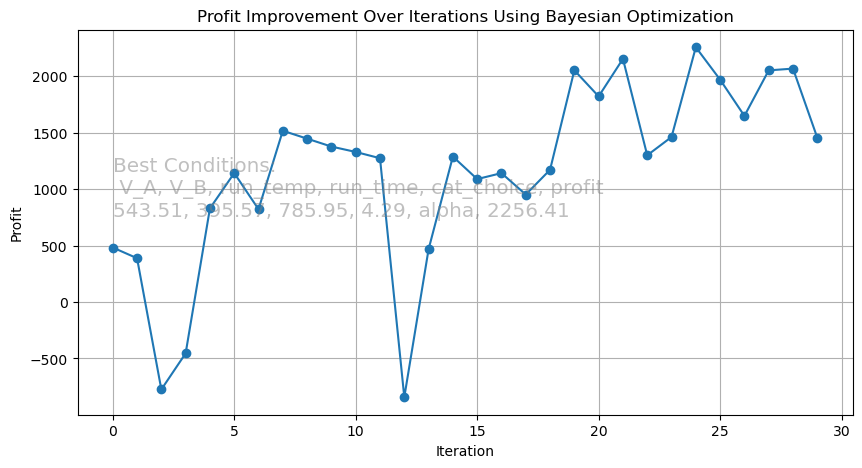

In [29]:
all_processes = generate_initial_data(n_samples=20, bounds=bounds) 
def upper_confidence_bound(X, model, kappa=1):
    # Ensure X is in the correct format (DataFrame) before prediction
    mu, sigma = model.predict(X, return_std=True)
    return mu + kappa * sigma  # UCB acquisition function
best_conditions = bayesian_optimization(num_iterations=30)  

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


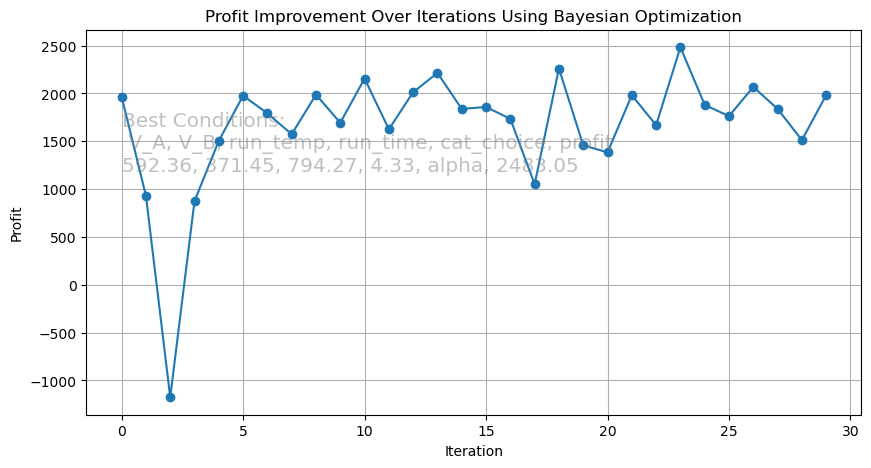

In [30]:
all_processes = generate_initial_data(n_samples=20, bounds=bounds) 
def upper_confidence_bound(X, model, kappa=0.1):
    # Ensure X is in the correct format (DataFrame) before prediction
    mu, sigma = model.predict(X, return_std=True)
    return mu + kappa * sigma  # UCB acquisition function
best_conditions = bayesian_optimization(num_iterations=30)  

initialize new data!


100%|██████████| 30/30 [00:06<00:00,  4.73it/s]


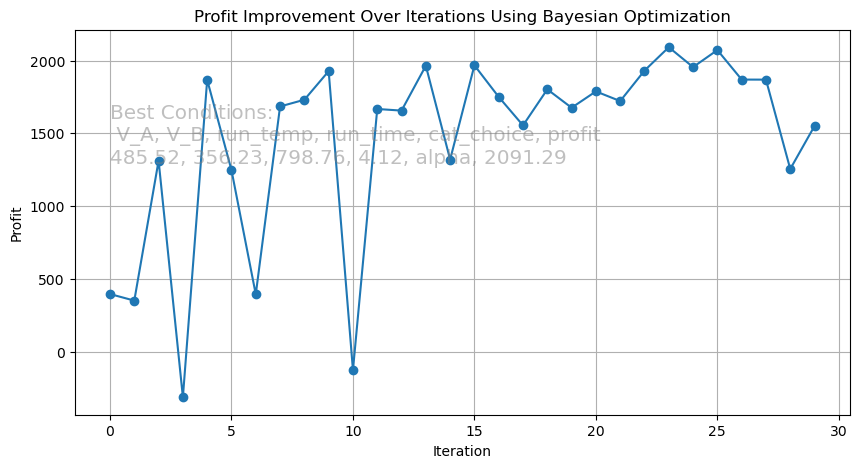

In [31]:
all_processes = generate_initial_data(n_samples=20, bounds=bounds) 
def upper_confidence_bound(X, model, kappa=0.01):
    # Ensure X is in the correct format (DataFrame) before prediction
    mu, sigma = model.predict(X, return_std=True)
    return mu + kappa * sigma  # UCB acquisition function
best_conditions = bayesian_optimization(num_iterations=30)  

#### Report

# Report
### Methods:
Suppose that since we need A and B for the reaction, the mechandizer of A and B both suggest they can give us some discount. mechandizer of B says they might give us more discount to make us use more B in our reactions. Therefore, when I buy more product, the price will be cheaper. 

Suppose the prize is listed as follows:

$$self.P_A = P_A * (1 - 0.5*V_A/V)$$
$$self.P_B = P_B * (1 - 0.9*V_B/V)$$

### Results:
It seems that after the discount of our mechandizers, our best profit even drops! If we do not consider the exact meaning of the function, instead we just think of it as a "black box" and optimize it, we will find it is not very unreasonable. The discount changes our sample space, so we will see some change in the final result definately. 

![](30_2205.79.png) 
| **Fig. 1 kappa = 3** |
|:--:| 

![](30_2161.21.png)
| **Fig. 2 kappa = 2** |
|:--:| 

![](30_2256.41.png)
| **Fig. 3 kappa = 1** |
|:--:| 

![](30_2483.05.png)
| **Fig. 3 kappa = 0.1** |
|:--:| 


![](30_2091.29.png)
| **Fig. 4 kappa = 0.01** |
|:--:| 

From a test figure below, I also show that if you increase the price of A and B (make the negative cash flow more negative), we will see the profit increase. Therefore, our optimization shows the correct trend.


![](show_trend.png)
| **Fig. 5 Increase the price, the profit increases** |
|:--:| 